# MNIST Digit Classification with Convolutional Neural Network (CNN)

**Discipline(s):** Computer Vision, Deep Learning

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

## 1. Import Statements

---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

## 2. Data Preprocessing

---



The first step is to preprocess our data.

In [2]:
BATCH_SIZE =64
EPOCHS =5
LEARNING_RATE =0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.69MB/s]


In [5]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)  # [60000, 28, 28]
print("Testing Images:", X_test.shape)    # [10000, 28, 28]
print("Training Labels:", y_train.shape)  # [60000]
print("Test Labels:", y_test.shape)       # [10000]

Training Images: torch.Size([60000, 28, 28])
Testing Images: torch.Size([10000, 28, 28])
Training Labels: torch.Size([60000])
Test Labels: torch.Size([10000])


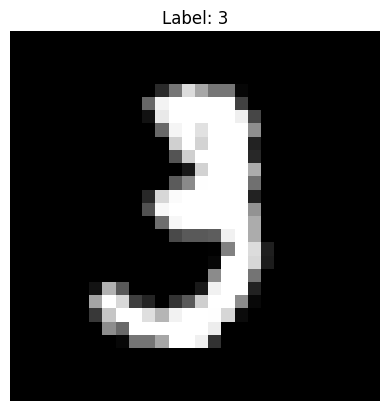

In [6]:
plt.imshow(X_train[10], cmap='gray')
plt.title(f"Label: {y_train[10].item()}")
plt.axis('off')
plt.show()

## 3. Convolutional Neural Network (CNN)

---



### 3.1. Define the Model

We then have to define our convolutional neural network.

차원 계산 공식
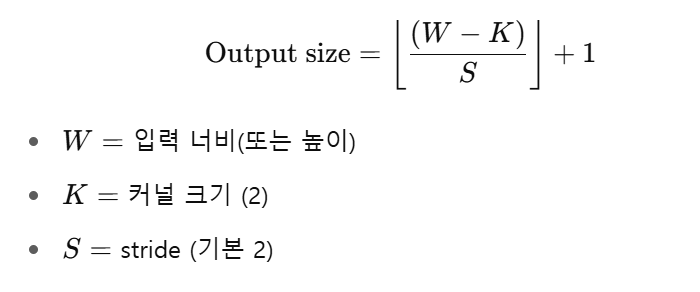

In [14]:
# CNN 모델 정의 -> 차원이 어떻게 될지 생각하면서 코드 빈칸을 채워주세요.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),#(32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#(32,14,14)

            # 두번째 conv 블록
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),#(64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),#(64, 7,7)

            #flatten: (64,7,7)=3136차원 벡터로
            nn.Flatten(),

            nn.Linear(in_features=64 * 7 * 7, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
# 모델 준비
model = SimpleCNN().to(DEVICE)

Once our model is defined, we can compile it using the Adam optimizer and the categorical cross-entropy loss function.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3.2. Train the Model

In [17]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [18]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [19]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.1362, Train Acc: 0.9578 | Test Loss: 0.0530, Test Acc: 0.9831
[Epoch 2] Train Loss: 0.0425, Train Acc: 0.9869 | Test Loss: 0.0425, Test Acc: 0.9850
[Epoch 3] Train Loss: 0.0284, Train Acc: 0.9911 | Test Loss: 0.0417, Test Acc: 0.9863
[Epoch 4] Train Loss: 0.0212, Train Acc: 0.9929 | Test Loss: 0.0320, Test Acc: 0.9893
[Epoch 5] Train Loss: 0.0159, Train Acc: 0.9947 | Test Loss: 0.0345, Test Acc: 0.9898


### 3.3. 시각화

Finally, we can plot the curves.

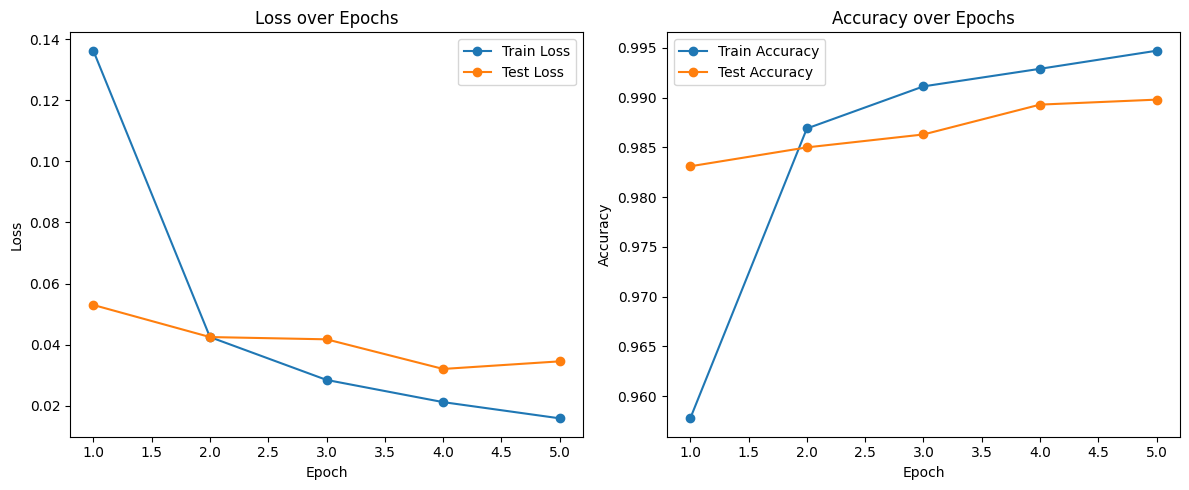

In [20]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [21]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

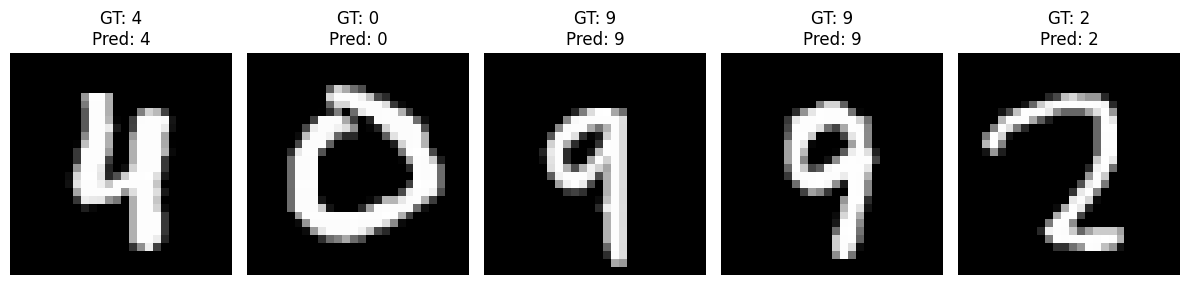

In [ ]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [22]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)


        # Skip connection: 채널 수가 다르면 어떤 convolution layer를 사용하는게 좋을지 생각해주세요.
        # 채널 수가 다르면 단순 덧셈이 불가능하니 1x1 conv로 차원 맞추기 (projection shortcut)
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x) #identity mapping 역할

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.relu(out)

In [25]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # layer 등을 추가로 더 쌓으셔도 됩니다.
        self.layer1 = ResidualBlock(16, 32)
        self.layer2 = ResidualBlock(32, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 빈칸을 채워주세요.
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # 빈칸을 채워주세요.
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [26]:
model = ResNetLike().to(DEVICE)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [28]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.2662, Train Acc: 0.9457 | Test Loss: 0.2210, Test Acc: 0.9275
[Epoch 2] Train Loss: 0.0515, Train Acc: 0.9864 | Test Loss: 0.0529, Test Acc: 0.9841
[Epoch 3] Train Loss: 0.0365, Train Acc: 0.9894 | Test Loss: 0.0587, Test Acc: 0.9807
[Epoch 4] Train Loss: 0.0300, Train Acc: 0.9911 | Test Loss: 0.0324, Test Acc: 0.9894
[Epoch 5] Train Loss: 0.0267, Train Acc: 0.9923 | Test Loss: 0.0360, Test Acc: 0.9879


### 시각화

Finally, we can plot the curves.

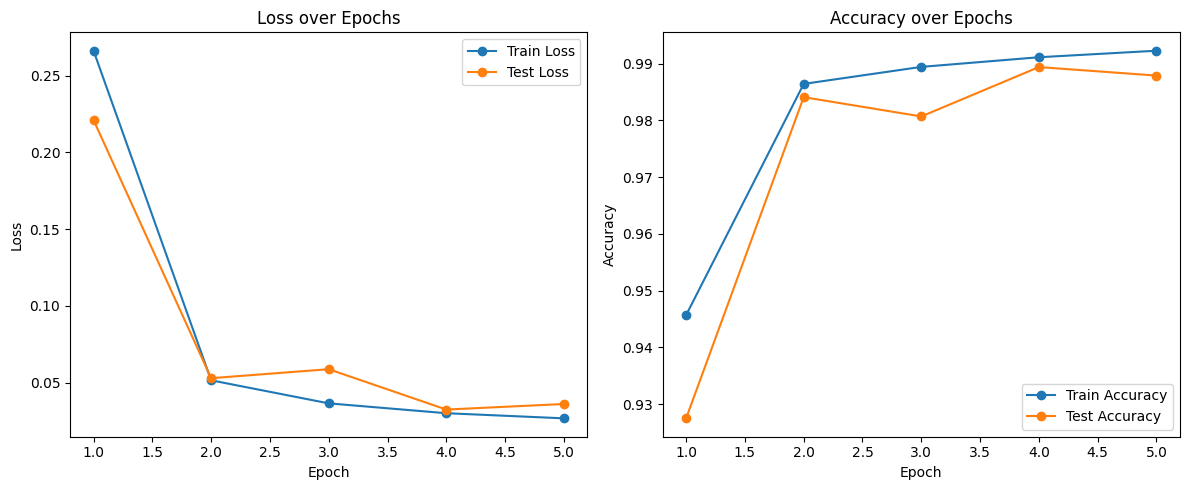

In [29]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [30]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

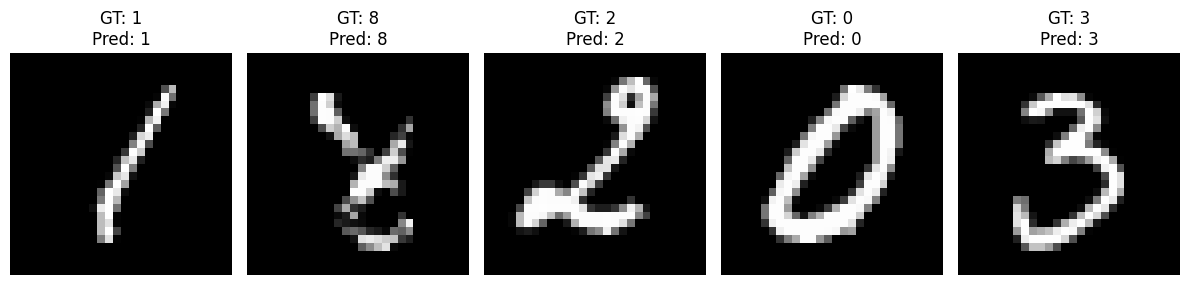

In [31]:
show_random_predictions(model, test_dataset, num_images=5)

# 다른 데이터셋으로도 진행해보기

In [32]:
pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha25

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import INFO, BloodMNIST


In [53]:
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [54]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

info = INFO['bloodmnist']
n_classes = len(info['label'])

train_dataset = BloodMNIST(split='train', transform=transform, download=True)
test_dataset = BloodMNIST(split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [55]:
class BloodCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.net(x)

model = BloodCNN().to(DEVICE)


In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [57]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(DEVICE), target.squeeze().long().to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Accuracy = {correct / total:.4f}")


Epoch 1: Loss = 182.4893, Train Accuracy = 0.6422
Epoch 2: Loss = 116.5095, Train Accuracy = 0.7746
Epoch 3: Loss = 95.9927, Train Accuracy = 0.8114
Epoch 4: Loss = 85.4803, Train Accuracy = 0.8348
Epoch 5: Loss = 77.9827, Train Accuracy = 0.8494
Epoch 6: Loss = 69.2605, Train Accuracy = 0.8660
Epoch 7: Loss = 64.4927, Train Accuracy = 0.8736
Epoch 8: Loss = 58.6262, Train Accuracy = 0.8886
Epoch 9: Loss = 54.7476, Train Accuracy = 0.8941
Epoch 10: Loss = 51.6262, Train Accuracy = 0.8992
Epoch 11: Loss = 45.7333, Train Accuracy = 0.9097
Epoch 12: Loss = 44.0668, Train Accuracy = 0.9153
Epoch 13: Loss = 40.6563, Train Accuracy = 0.9222
Epoch 14: Loss = 39.5188, Train Accuracy = 0.9238
Epoch 15: Loss = 35.7002, Train Accuracy = 0.9323
Epoch 16: Loss = 30.2381, Train Accuracy = 0.9420
Epoch 17: Loss = 27.2470, Train Accuracy = 0.9502
Epoch 18: Loss = 26.6568, Train Accuracy = 0.9497
Epoch 19: Loss = 23.8296, Train Accuracy = 0.9552
Epoch 20: Loss = 21.5920, Train Accuracy = 0.9593


In [58]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.squeeze().long().to(DEVICE)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.8872


In [61]:
def visualize_predictions(model, dataloader, n=10):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 5))

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(DEVICE)
            target = target.squeeze().cpu().numpy()
            outputs = model(data)
            preds = outputs.argmax(dim=1).cpu().numpy()

            for i in range(data.size(0)):
                if images_shown >= n:
                    break
                image = data[i].cpu().squeeze().numpy()

                gt_label = label_text.get(str(target[i]), f"{target[i]}")
                pred_label = label_text.get(str(preds[i]), f"{preds[i]}")

                plt.subplot(2, n // 2, images_shown + 1)
                plt.imshow(image, cmap='gray')
                plt.axis('off')
                plt.title(f"GT: {gt_label[:6]}\nPred: {pred_label[:6]}")

                images_shown += 1
            if images_shown >= n:
                break
    plt.tight_layout()
    plt.show()


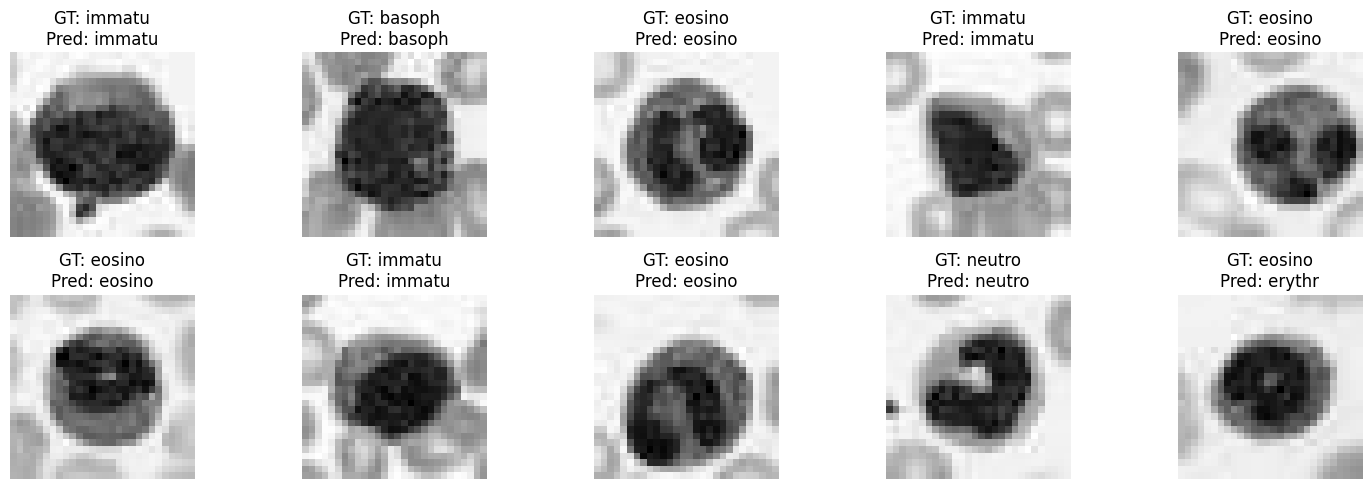

In [62]:
visualize_predictions(model, test_loader, n=10)
